In [80]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __neg__(self):
        return self * -1

    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other ** -1

    def __rtruediv__(self, other):
        return other * self ** -1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad  
        out._backward = _backward
        return out
    
    def __gt__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        return int(self.data) > int(other.data)
    
    def ReLU(self):
        out=Value(0 if self.data>Value(0).data else self.data,(self,),'ReLU')
        def _backward():
            self.grad+=(out.data>0)*out.grad
        out._backward=_backward
        return out
    
    def Sigmoid(self):
        x=self.data
        s=1/(1+math.exp(-x))
        out=Value(s,(self,),'Sigmoid')
        def _backward():
            self.grad+=s*(1-s) * out.grad
        out._backward=_backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [81]:

class Module:
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):
    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        # Change 2: Ensure the activation function used in neurons is `tanh`
        return act.ReLU() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'tanh' if self.nonlin else 'linear'} Neuron({len(self.w)})"

class Layer(Module):
    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"


In [82]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{%s|data %.4f|grad %.4f}" % (n.label,n.data,n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

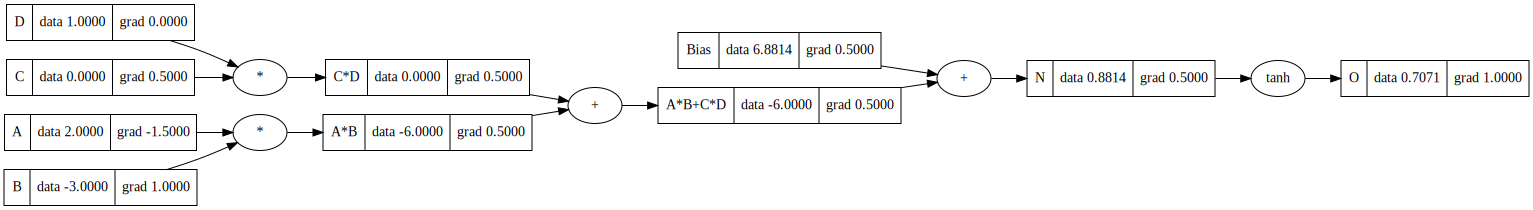

In [83]:
a = Value(2.0,label='A') 
b = Value(-3.0,label='B') 
c = Value(0.0,label='C') 
d=Value(1.0,label='D') 
bias=Value(6.8813735870,label = 'Bias')
ab=a*b;ab.label='A*B' 
cd=c*d;cd.label='C*D' 
abcd=ab+cd;abcd.label='A*B+C*D'
n=abcd+bias;n.label='N'
o = n.tanh() ;o.label='O' 
o.backward()
draw_dot(o)

In [84]:

learning_rate=0.01
epochs=1000

N=MLP(3,[8,8,1])

X=[
    [2.0,3.0,-1.0],[3.0,-1.0,0.5],[0.5,1.0,1.0],[1.0,1.0,-1.0],
    [-2.0,-3.0,1.0],[-3.0,1.0,-0.5],[-0.5,-1.0,-1.0],[-1.0,-1.0,1.0],
    [2.5,3.5,-0.5],[3.5,-0.5,0.0],[0.0,1.5,0.5],[1.5,1.5,-1.5],
    [-2.5,-3.5,1.5],[-3.5,1.5,-0.75],[-0.75,-1.5,-1.5],[-1.5,-1.5,1.5]
]

Y=[1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0]


def mse_loss(pred,target):
    return sum((p-Value(t))**2 for p,t in zip(pred,target))/(2*len(Y))


In [90]:

for epoch in range(epochs):
    y_pred=[N(list(x)) for x in X]
    loss=mse_loss(y_pred,Y)
    N.zero_grad()
    loss.backward()
    for p in N.parameters():
        p.data-=learning_rate*p.grad
    if epoch%10==0:
        print(f"Epoch {epoch}, Loss: {loss.data}")

def threshold(pred,threshold=0.0):
    return 1.0 if pred.data>threshold else -1.0

def Accuracy(N,X,Y):
    correct=0
    for x,y in zip(X,Y):
        pred=N(list(x))
        pred_label=threshold(pred)
        if pred_label==y:
            correct+=1
    accuracy=correct/len(Y)
    return accuracy


Epoch 0, Loss: 0.26978557818400173
Epoch 10, Loss: 0.2695570439462047
Epoch 20, Loss: 0.2693295107413458
Epoch 30, Loss: 0.2691029684835095
Epoch 40, Loss: 0.2688774072575586
Epoch 50, Loss: 0.2686528173146112
Epoch 60, Loss: 0.26842918906767865
Epoch 70, Loss: 0.26820651308745763
Epoch 80, Loss: 0.26798478009827054
Epoch 90, Loss: 0.2677639809741488
Epoch 100, Loss: 0.26754410673505113
Epoch 110, Loss: 0.2673251485432153
Epoch 120, Loss: 0.2671070976996335
Epoch 130, Loss: 0.2668899456406503
Epoch 140, Loss: 0.2666736839346759
Epoch 150, Loss: 0.2664583042790112
Epoch 160, Loss: 0.26624379849678
Epoch 170, Loss: 0.2660301585339637
Epoch 180, Loss: 0.2658173764565359
Epoch 190, Loss: 0.2656054444476908
Epoch 200, Loss: 0.2653943548051631
Epoch 210, Loss: 0.2651840999386367
Epoch 220, Loss: 0.26497467236723615
Epoch 230, Loss: 0.26476606471710007
Epoch 240, Loss: 0.26455826971903185
Epoch 250, Loss: 0.2643512802062264
Epoch 260, Loss: 0.26414508911206663
Epoch 270, Loss: 0.2639396894679

In [92]:

test_input=[
    [2.0,3.0,-1.0],[3.0,-1.0,0.5],[0.5,1.0,1.0],[1.0,1.0,-1.0]
]

test_output=[N(list(x)) for x in test_input]

print("Test Outputs:")
for i,output in enumerate(test_output):
    print(f"Input {test_input[i]} -> Output {output.data}")

accuracy=Accuracy(N,X,Y)
print(f"Accuracy: {accuracy*100}%")


Test Outputs:
Input [2.0, 3.0, -1.0] -> Output 0.731495181349472
Input [3.0, -1.0, 0.5] -> Output -1.1851800957369605
Input [0.5, 1.0, 1.0] -> Output -0.08912868891191914
Input [1.0, 1.0, -1.0] -> Output 0.5919898901414078
Accuracy: 81.25%
